In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


In [4]:
# Import Libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import  KFold, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV,train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
import gc

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Multiple outputs in jupyter cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
#Loading the Dataset
train = pd.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e7/test.csv')


print('Shape of train data is : ' , train.shape)
print('train data columns: ' , train.columns)

Shape of train data is :  (11504798, 12)
train data columns:  Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')


# Dataset Description


1. id
2. Gender: (Male/Female)
3. Age: The age of the customer in years. Age could affect the probability of responding positively as different age groups might have different risk perceptions or insurance needs.
4. Driving_License: Indicates whether the customer has a valid driving license.(0/1)
5. Region_Code: A code representing the region where the customer resides. Different regions may have varying risk factors or demographic profiles affecting the response rate.
6. Previously_Insured: Indicates whether the customer already has an existing insurance policy. A value of 1 means they are already insured, which might make them less likely to respond positively to a new offer.
7. Vehicle_Age: The age of the customer’s vehicle. Newer or older vehicles might have different insurance needs or risk profiles.
8. Vehicle_Damage:Indicates whether the customer’s vehicle has been damaged in the past. A value of True means there was previous damage, which might increase the likelihood of needing insurance. (True/False)

9. Annual_Premium: The annual premium amount that the customer pays for their current insurance. This could reflect the customer’s financial capacity and influence their response to an insurance offer.

10. Policy_Sales_Channel: The sales channel through which the insurance policy was sold (e.g., agents, online, etc.). Different sales channels might have varying effectiveness in converting customers.
11. Vintage: The number of days since the customer’s policy was initiated. This can reflect customer loyalty or recent engagement with the insurance provider.
12. Response: target(0/1)**

# Data Exploration

In [7]:
train.shape
train.head()
pd.set_option('display.float_format', '{:.2f}'.format)
train.info()

(11504798, 12)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


# What we should be mindful of:
* #### There are variables like Policy Sales Channel that have int value but are actually categorical
* #### unless specified that the values are odered thse should be modelled as categories!!!! 
* #### Binning is an option

In [9]:
# we can use sweetviz or pandas report for the exploratory data analysis 
!pip install sweetviz
import sweetviz as sv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 74.0 MB/s eta 0:00:00:00:0100:01


In [10]:
feature_config = sv.FeatureConfig(skip="id", force_text=["Region_Code","Policy_Sales_Channel"])

In [11]:
report=sv.analyze(train,target_feat='Response',feat_cfg=feature_config)

                                             |          | [  0%]   00:00 -> (? left)


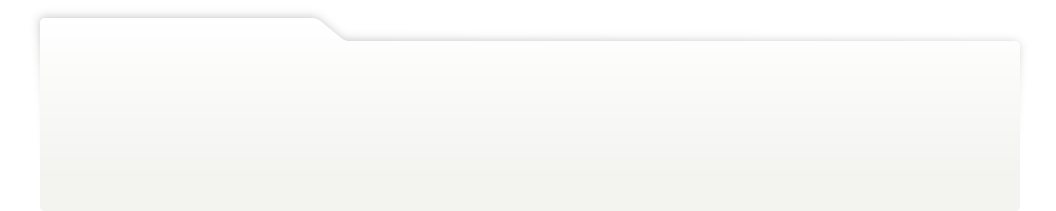
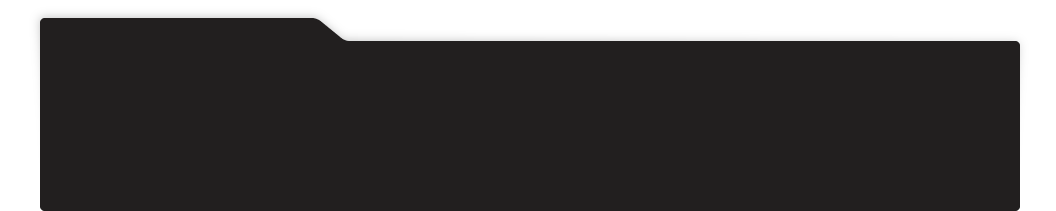
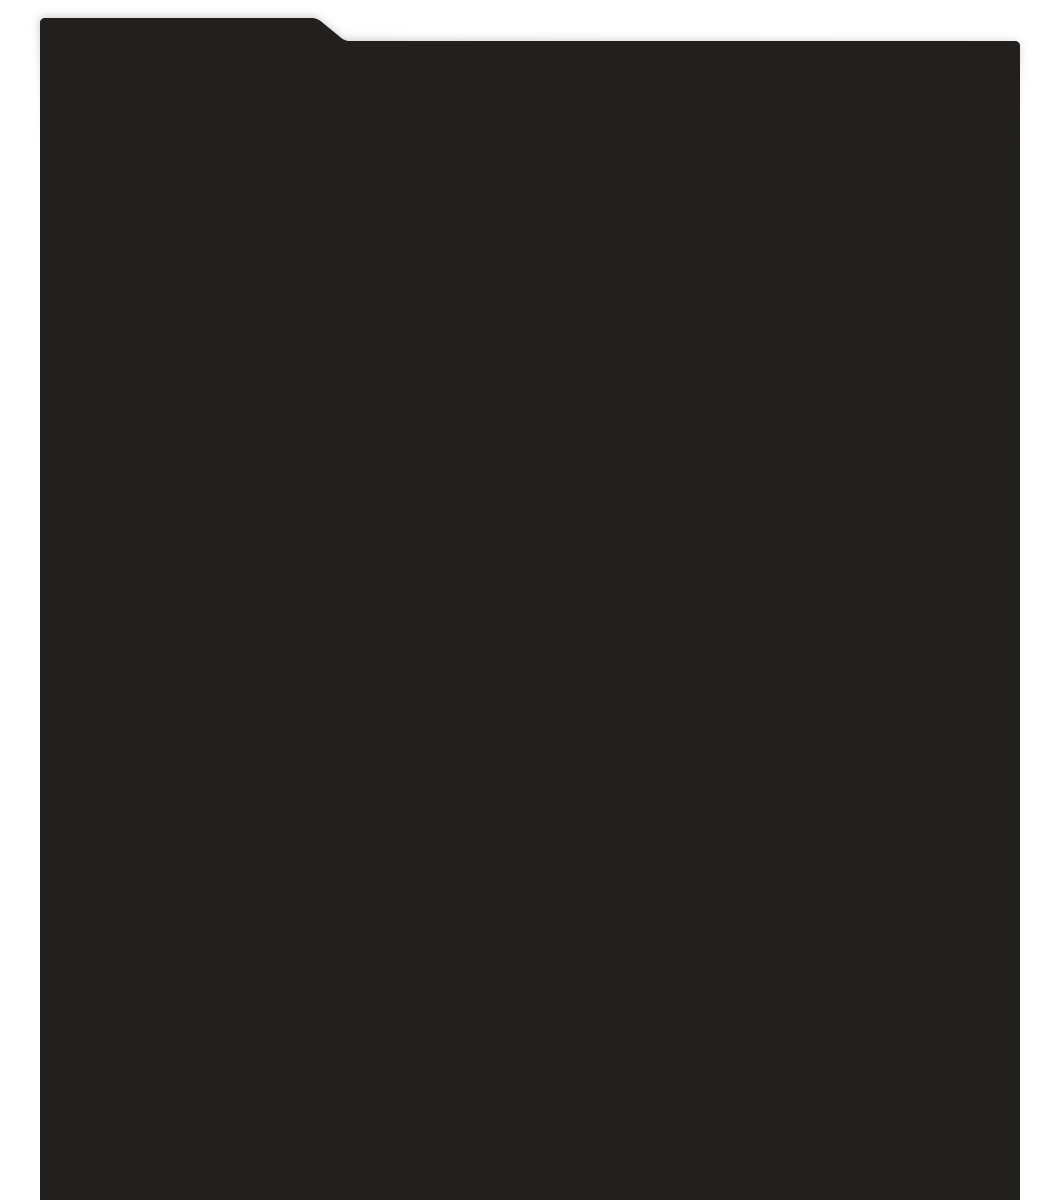
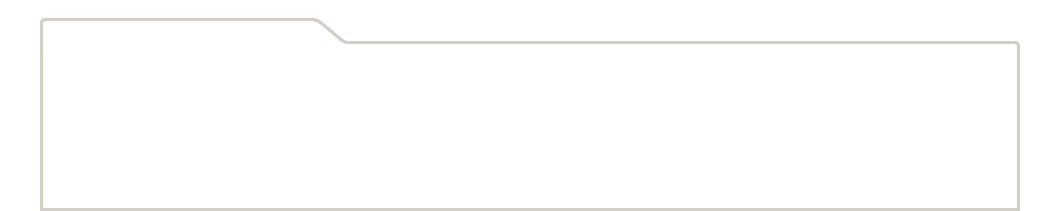
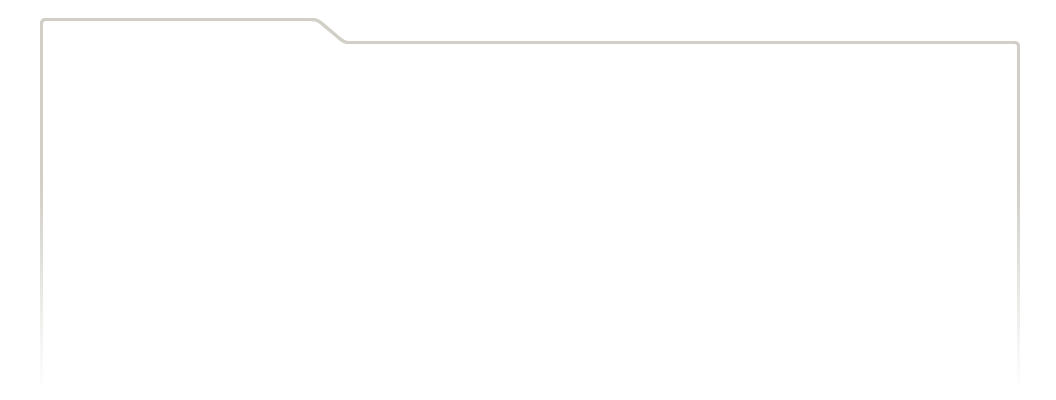
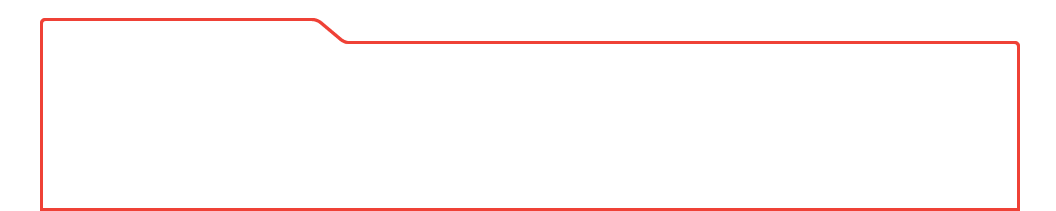
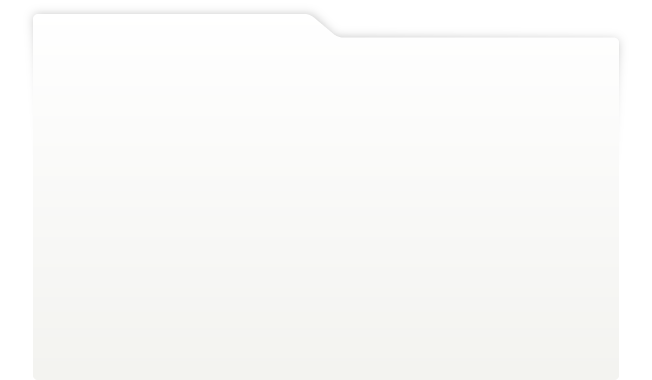
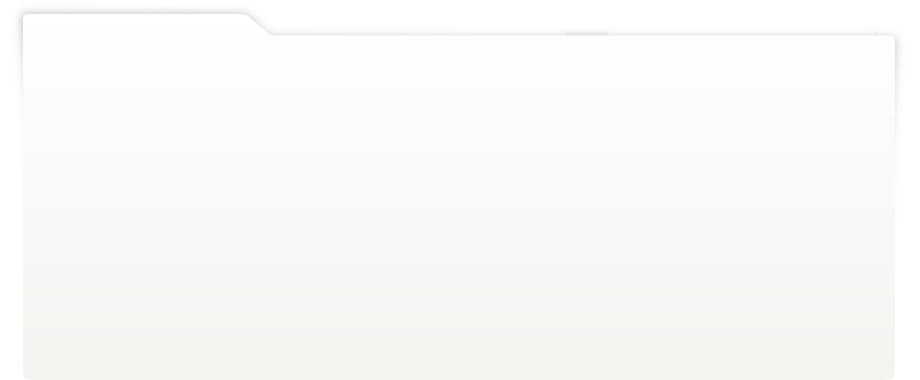
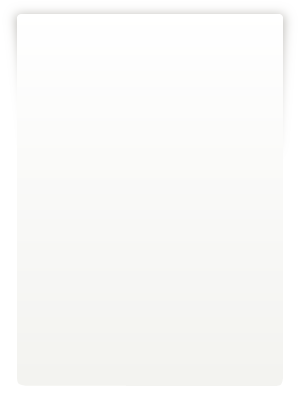
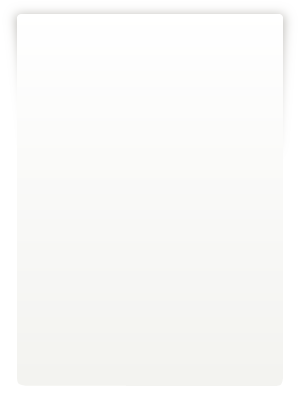
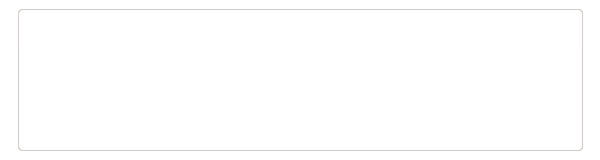
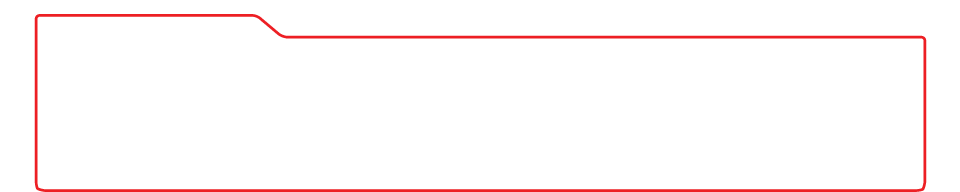
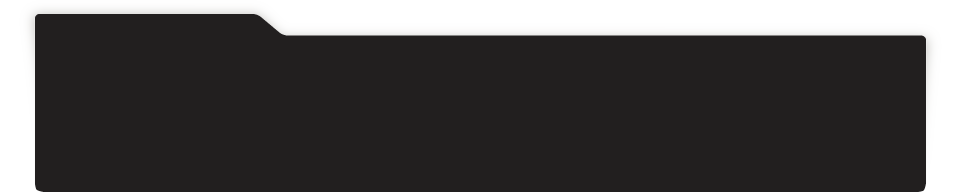
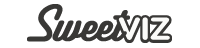
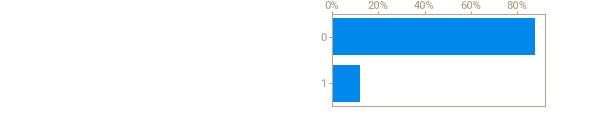
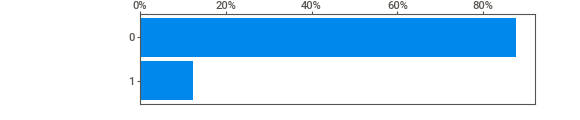
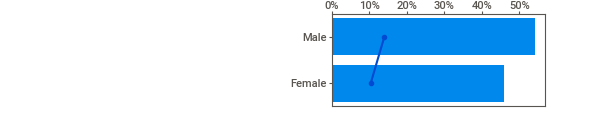
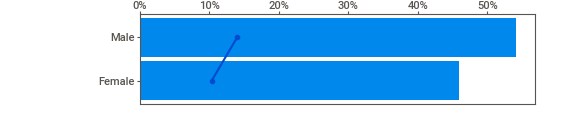
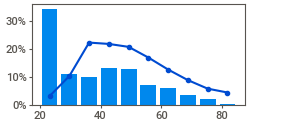
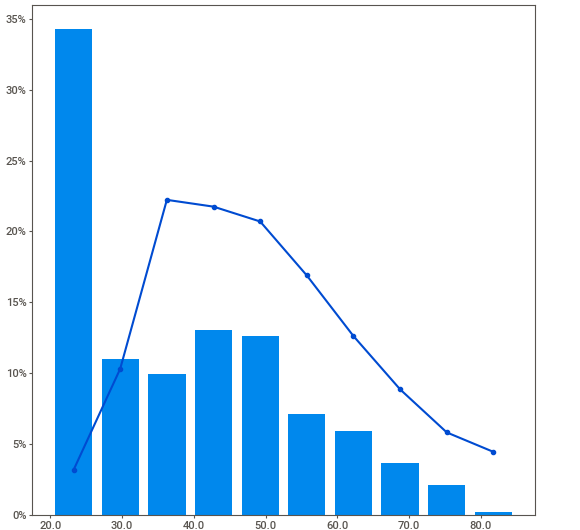
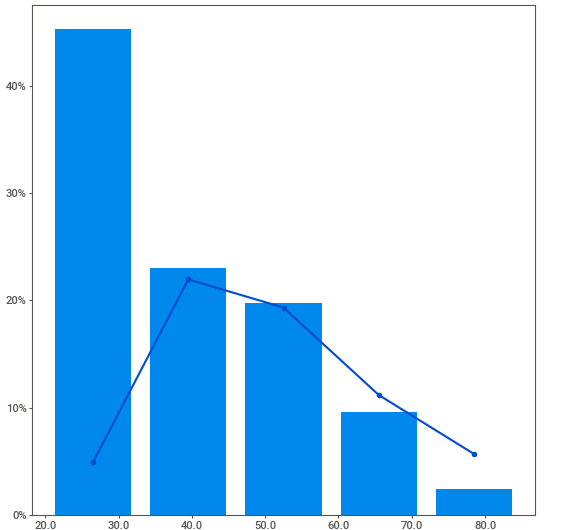
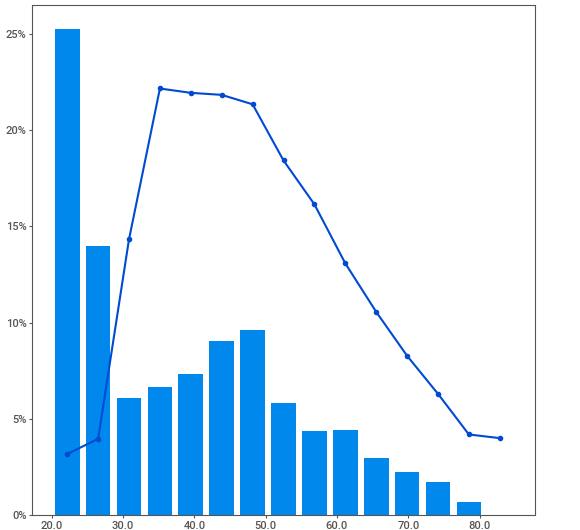
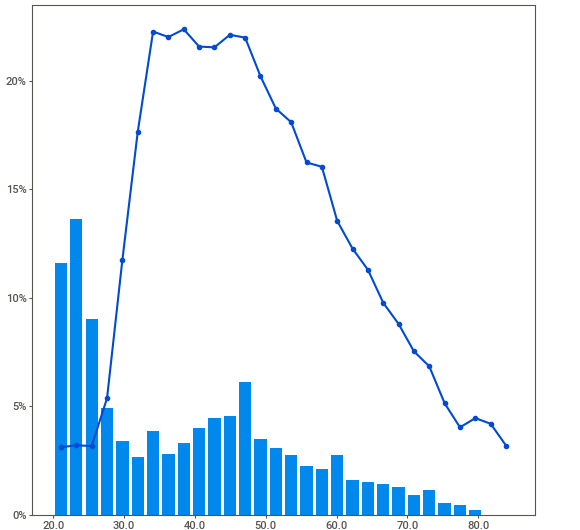
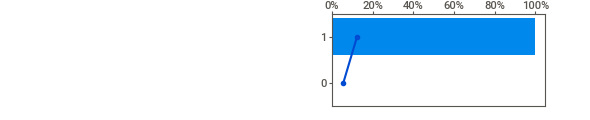
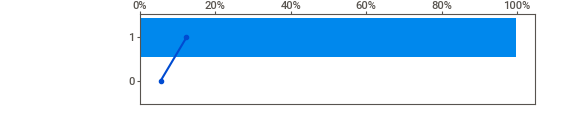
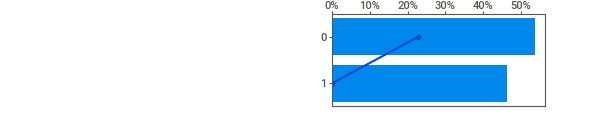
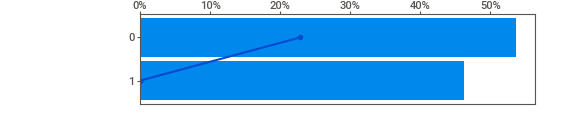
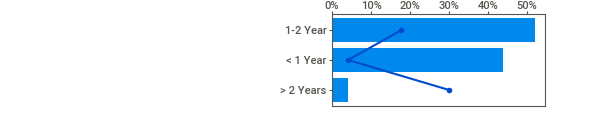
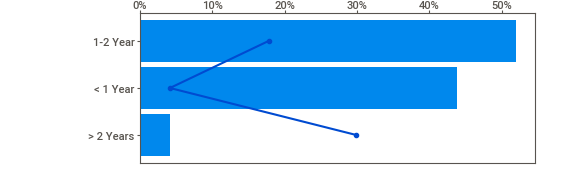
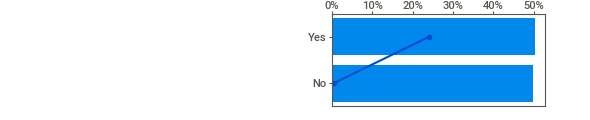
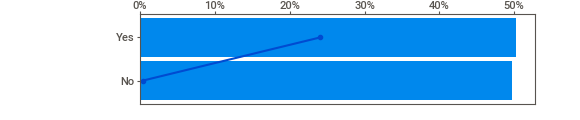
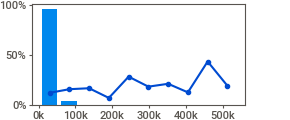
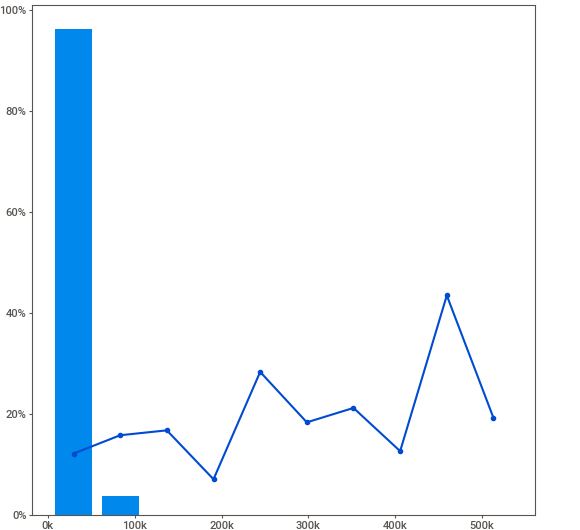
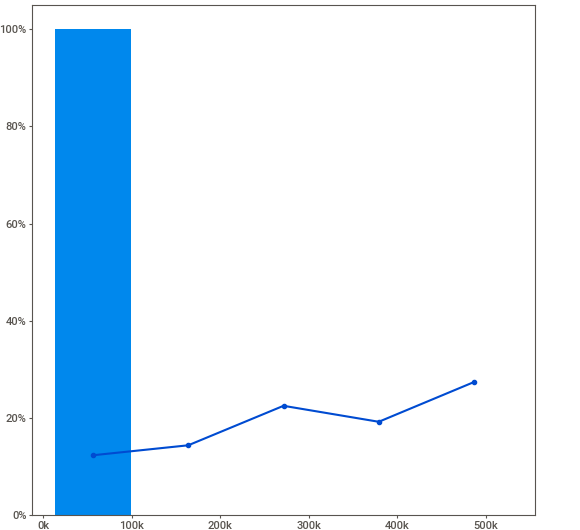
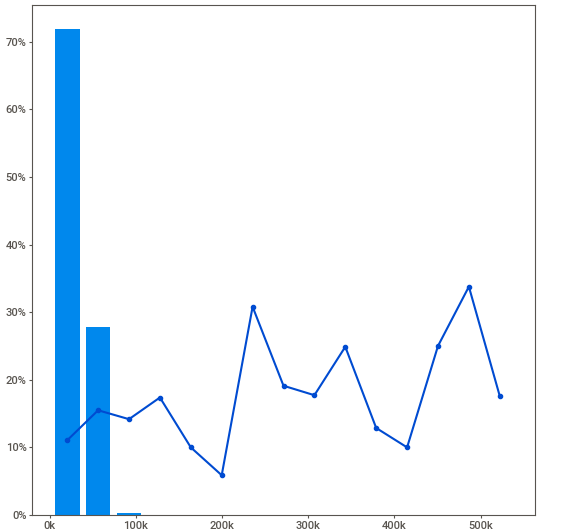
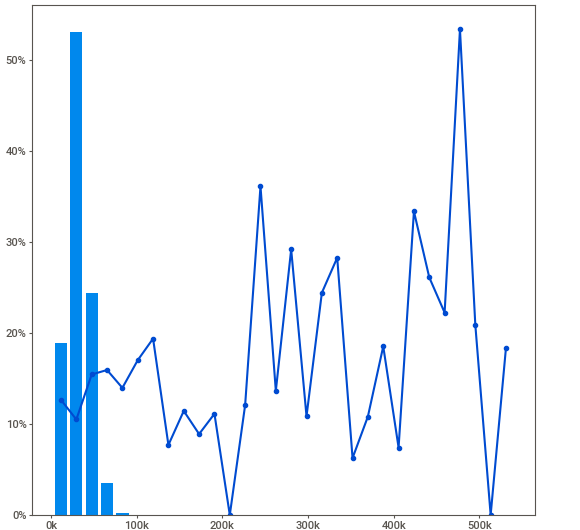
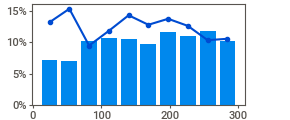
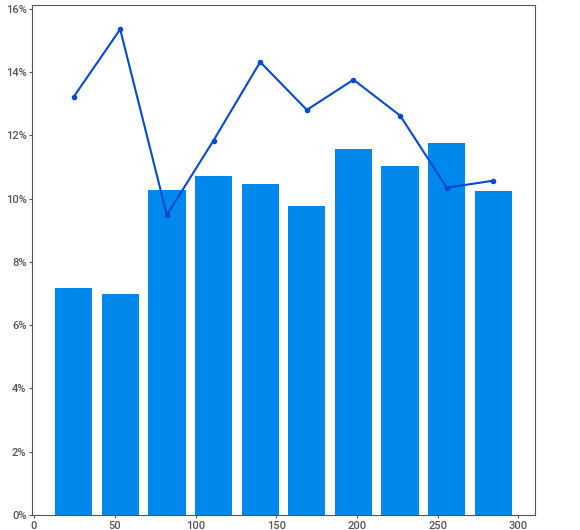
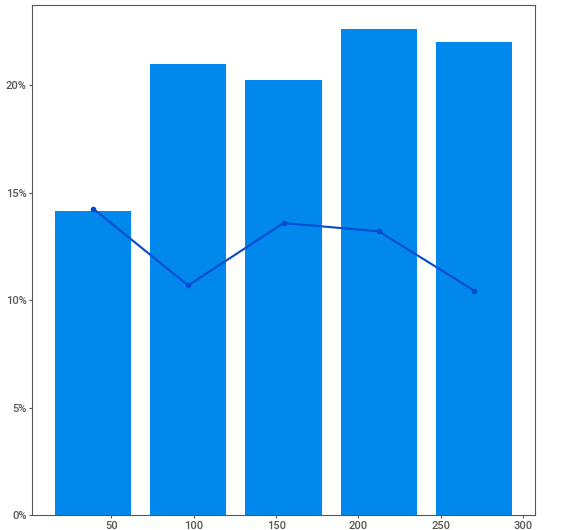
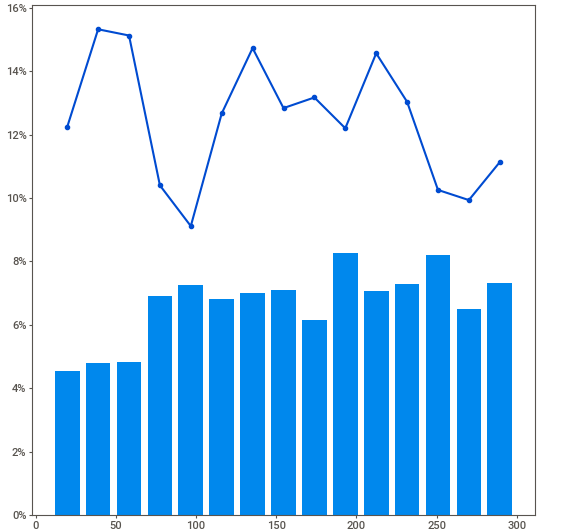
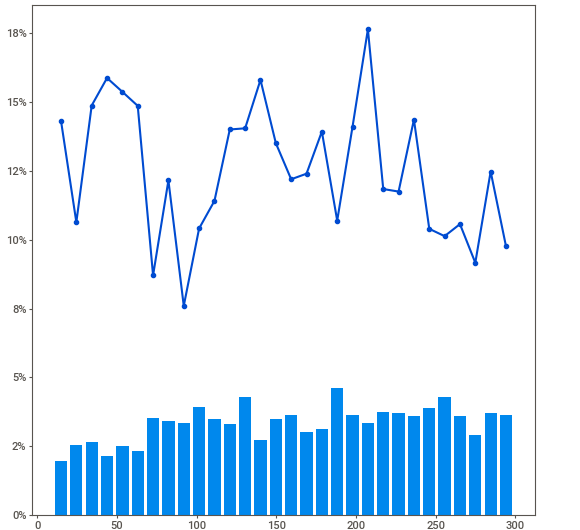
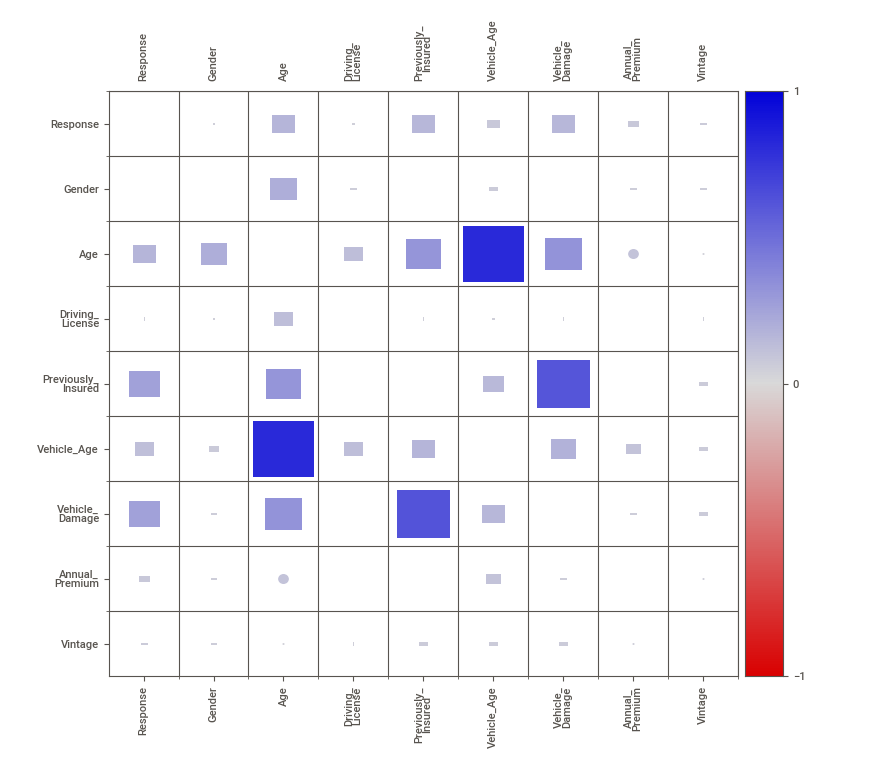
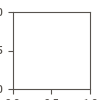

In [12]:
# 
report.show_notebook( w=None, 
                h=None, 
                scale=None,
                layout='widescreen',
                filepath=None,
                file_layout=None,
                file_scale=None)

# Suppose we want to do EDA manually instead of the Sweetviz.... We can easily look at
### Numerical Variables : mean, meadian, missings percentage ,skewness
### Categorical Variables

In [54]:
numerical_variables=['Age', 'Driving_License', 'Previously_Insured', 'Annual_Premium', 'Vintage']
categorical_variables=['Gender','Region_Code','Vehicle_Age','Vehicle_Damage','Policy_Sales_Channel']

In [16]:
# Average response in the data
train['Response'].mean()

0.12299729208631043

In [20]:
# Adding missing,95th percentile, skewness to the describe
num_summary=train[numerical_variables].describe()
perc_95=dict()
skewness=dict()
missing=dict()

for i in numerical_variables:
    missing[i]=train[i].isna().mean()
    perc_95[i]=train[i].quantile(.95)
    skewness[i]=train[i].skew()

num_summary.loc['perc_95']=perc_95
num_summary.loc['skewness']=skewness
num_summary.loc['missing']=missing

In [46]:
num_summary.loc['25%','Age']

24.0

In [21]:
# Summary of the numerical variables to aide in decisions for further exploration or transformation
num_summary

,Age,Driving_License,Previously_Insured,Annual_Premium,Vintage
count,11504798.00,11504798.00,11504798.00,11504798.00,11504798.00
mean,38.38,1.00,0.46,30461.37,163.90
std,14.99,0.04,0.50,16454.75,79.98
min,20.00,0.00,0.00,2630.00,10.00
25%,24.00,1.00,0.00,25277.00,99.00
50%,36.00,1.00,0.00,31824.00,166.00
75%,49.00,1.00,1.00,39451.00,232.00
max,85.00,1.00,1.00,540165.00,299.00
perc_95,67.00,1.00,1.00,54155.00,284.00
skewness,0.64,-22.42,0.15,0.78,-0.11


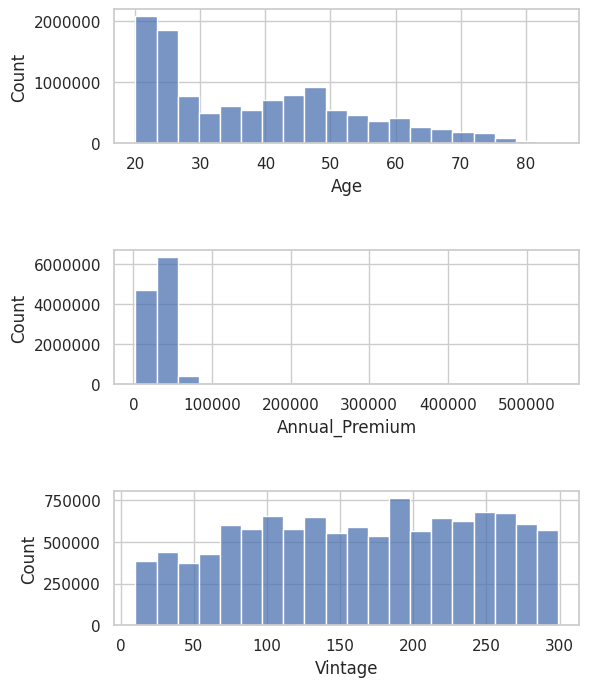

In [31]:
# Distribution of Age,Annual Premium and Vintage
sns.set(style="whitegrid")
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,8))
sns.histplot(train['Age'],bins=20,ax=axs[0])
sns.histplot(train['Annual_Premium'],bins=20,ax=axs[1])
sns.histplot(train['Vintage'],bins=20,ax=axs[2])
plt.subplots_adjust(wspace=0.8, hspace=0.8)
plt.show();

* # Annual premium has Outlier Problem

In [73]:
# Summary for Categorical Variables
## Number of unique values , what are they ,% of data in each of the top 5 values , avg Response rate in each value
cat_summary=pd.DataFrame(columns=categorical_variables)
num_unique_values=dict()
unique_values=dict()
top_values_10=dict()
top_values_10_response=dict()

In [78]:
# Code created dataframe that contains Number of unique values , what are they ,% of data in each of the top 5 values , avg Response rate in each value
for i in categorical_variables:
    num_unique_values[i]=len(list((train[i].unique())))
    l=list((train[i].unique()))
    l.sort()
    unique_values[i]=l
    top_values_10_response[i]=dict(train.groupby(i).agg({'id':"count","Response":"mean"}).nlargest(10,'id')['Response'])
    top_values_10[i]=dict(100*train.groupby(i).agg({'id':"count","Response":"mean"}).nlargest(10,'id')["id"]/train.groupby(i).agg({'id':"count","Response":"mean"})['id'].sum())
    
cat_summary.loc['num_unique_values']=num_unique_values
cat_summary.loc['unique_values']=unique_values
cat_summary.loc['top_values_5']=top_values_10
cat_summary.loc['top_values_5_response']=top_values_10_response

In [80]:
pd.set_option('display.max_colwidth', None)
cat_summary
cat_summary['Gender']
# Reset the option to its default value
pd.reset_option('display.max_colwidth')

,Gender,Region_Code,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel
num_unique_values,2,54,3,2,152
unique_values,"[Female, Male]","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 39.2, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0]","[1-2 Year, < 1 Year, > 2 Years]","[No, Yes]","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 73.0, 74.0, 75.0, 76.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, ...]"
top_values_5,"{'Male': 54.1351008509667, 'Female': 45.8648991490333}","{28.0: 29.99671962949719, 8.0: 8.874871162448919, 46.0: 5.025798801508727, 41.0: 4.846508387196368, 15.0: 3.511378470095694, 30.0: 3.19264188732388, 29.0: 2.9391737256056127, 50.0: 2.6278949008926538, 11.0: 2.4186517659849396, 36.0: 2.2768413665324676}","{'1-2 Year': 52.00159098838589, '< 1 Year': 43.843838023057856, '> 2 Years': 4.1545709885562525}","{'Yes': 50.26797515262763, 'No': 49.73202484737237}","{152.0: 36.2125697469873, 26.0: 21.15166211523227, 124.0: 19.683005299180394, 160.0: 5.566199423927304, 156.0: 2.7527036980571062, 122.0: 2.4710472969625368, 157.0: 1.7442461832011305, 154.0: 1.4782267363581698, 151.0: 0.9706211269419941, 163.0: 0.7414211010049894}"
top_values_5_response,"{'Male': 0.13968838820744706, 'Female': 0.10329651461605287}","{28.0: 0.19181081070116968, 8.0: 0.08771776901108286, 46.0: 0.09616262659804084, 41.0: 0.11413050301211843, 15.0: 0.06743453216395982, 30.0: 0.06950044513172904, 29.0: 0.11674838679150426, 50.0: 0.0639789107411009, 11.0: 0.1077872932247063, 36.0: 0.07803134997289518}","{'1-2 Year': 0.17772509234159017, '< 1 Year': 0.0414042419478425, '> 2 Years': 0.299049113447356}","{'Yes': 0.24052964183157885, 'No': 0.0041983239212880245}","{152.0: 0.026222323887356843, 26.0: 0.20776295112794313, 124.0: 0.1924963236755296, 160.0: 0.02069552453230894, 156.0: 0.20492716921434953, 122.0: 0.17165630748991342, 157.0: 0.26049473768139053, 154.0: 0.2498544691209935, 151.0: 0.029310097789877136, 163.0: 0.3075768766339582}"


num_unique_values                                                                   2
unique_values                                                          [Female, Male]
top_values_5                   {'Male': 54.1351008509667, 'Female': 45.8648991490333}
top_values_5_response    {'Male': 0.13968838820744706, 'Female': 0.10329651461605287}
Name: Gender, dtype: object

# Now options for converting categorical variables for modelling prupose is target encoding, volume based encoding
## we will use optbinning for WOE transformation of categorical variables and also numerical variables

In [87]:
#!pip install optbinning
#import optbinning

In [86]:
from optbinning import BinningProcess

In [88]:
selection_criteria = {
    "iv": {"min": 0.0, "max": 20, "strategy": "highest", "top": 20}
}

In [92]:
variable_name=[ 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage']

In [97]:
# Split data into train and test
X_train,X_test=train_test_split(train,test_size=0.33,random_state=123)

y_train=X_train['Response']
y_test=X_test['Response']

In [98]:
np.seterr(all='ignore')
X=X_train[variable_name]
y=y_train

binning_process = BinningProcess(variable_name,
                                 categorical_variables=categorical_variables,
                                 selection_criteria=selection_criteria)
binning_process.fit(X, y)

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

BinningProcess(categorical_variables=['Gender', 'Region_Code', 'Vehicle_Age',
                                      'Vehicle_Damage',
                                      'Policy_Sales_Channel'],
               selection_criteria={'iv': {'max': 20, 'min': 0.0,
                                          'strategy': 'highest', 'top': 20}},
               variable_names=['Gender', 'Age', 'Driving_License',
                               'Region_Code', 'Previously_Insured',
                               'Vehicle_Age', 'Vehicle_Damage',
                               'Annual_Premium', 'Policy_Sales_Channel',
                               'Vintage'])

In [99]:
# Summary of binning and information values within varaibles
binning_process.summary()

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,Gender,categorical,OPTIMAL,True,2,0.03,0.00,0.08,0.08
1,Age,numerical,OPTIMAL,True,10,0.68,0.08,0.41,0.60
2,Driving_License,numerical,OPTIMAL,True,1,0.00,0.00,0,0.00
3,Region_Code,categorical,OPTIMAL,True,10,0.21,0.03,0.25,0.68
4,Previously_Insured,numerical,OPTIMAL,True,2,3.22,0.22,0.53,0.00
5,Vehicle_Age,categorical,OPTIMAL,True,2,0.55,0.07,0.33,0.57
6,Vehicle_Damage,categorical,OPTIMAL,True,2,2.36,0.22,0.55,0.00
7,Annual_Premium,numerical,OPTIMAL,True,9,0.06,0.01,0.13,0.22
8,Policy_Sales_Channel,categorical,OPTIMAL,True,4,0.85,0.10,0.42,0.29
9,Vintage,numerical,OPTIMAL,True,4,0.02,0.00,0.06,0.05


In [100]:
# general rule of thumb for selecting variables using information value is 0.02 to 0.7.
# Driving license, Previously Insured should be investigated for such a low/high value 
# For simplicity sake we will use them and see if we can they coem out to be significant in our logistic regression

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 21.50)",453265,0.06,439921,13344,0.03,1.53,0.08,0.01
1,"[21.50, 26.50)",2187727,0.28,2117355,70372,0.03,1.44,0.34,0.04
2,"[26.50, 29.50)",522333,0.07,487191,35142,0.07,0.66,0.02,0.00
3,"[29.50, 33.50)",427944,0.06,352955,74989,0.18,-0.42,0.01,0.00
4,"[33.50, 38.50)",530974,0.07,411788,119186,0.22,-0.72,0.05,0.01
5,"[38.50, 47.50)",1457845,0.19,1140197,317648,0.22,-0.69,0.11,0.01
6,"[47.50, 50.50)",420199,0.05,332859,87340,0.21,-0.63,0.03,0.00
7,"[50.50, 57.50)",708089,0.09,582951,125138,0.18,-0.43,0.02,0.00
8,"[57.50, 65.50)",534295,0.07,464707,69588,0.13,-0.07,0.00,0.00
9,"[65.50, inf)",465543,0.06,430180,35363,0.08,0.53,0.01,0.00


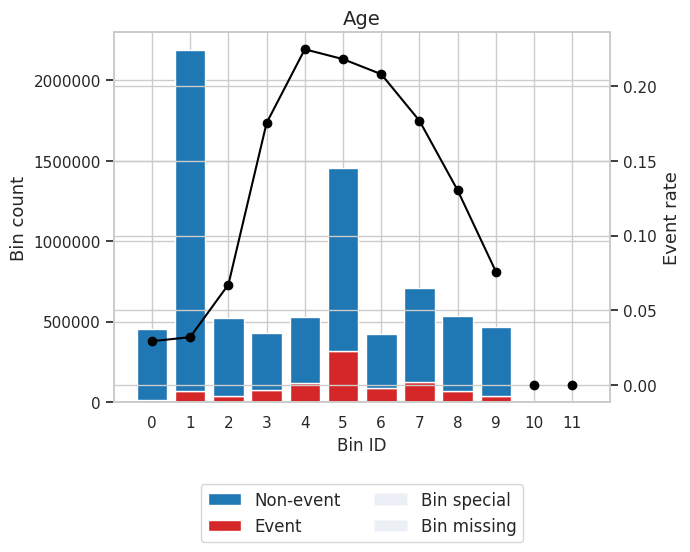

In [115]:
# Seeing the binned variable
optb = binning_process.get_binned_variable("Age")
optb.binning_table.build()
optb.binning_table.plot(metric="event_rate")

# Thus using the weight of evidence method allows for captruing the non linearity in data

In [102]:
X_transform = binning_process.transform(X.reset_index(), metric="woe")

In [113]:
X_transform=X_transform.drop(['Driving_License'],axis=1)

In [116]:
# Getting test data ready
X_transform_test = binning_process.transform(X_test[variable_name].reset_index(), metric="woe")
X_transform_test=X_transform_test.drop(['Driving_License'],axis=1)

In [118]:
# Fit logistic regression
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_transform, y_train)

# Predict and evaluate
y_pred = logistic_regression_model.predict(X_transform_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

LogisticRegression(max_iter=1000)

Accuracy: 0.876994951250914


In [125]:
# Auc 
print("Train auc",roc_auc_score(y_train,logistic_regression_model.predict_proba(X_transform)[:,1]))
print("Test auc",roc_auc_score(y_test,logistic_regression_model.predict_proba(X_transform_test)[:,1]))

Train auc 0.8526750323788992
Test auc 0.8526676451204169


In [122]:
# Since this is an imbalanced class problem looking at other confusion metric should be considered
from sklearn.metrics import roc_auc_score,f1_score,precision_score,recall_score
f1_score(y_test,y_pred)
precision_score(y_test,y_pred)
recall_score(y_test,y_pred)

0.011083511741026146

0.4952687358062074

0.005604466440660543

In [138]:
# Manipulating the cutoff threshold should get us closer to desired recall and precision values
y_pred = (logistic_regression_model.predict_proba(X_transform_test)[:,1]>=0.15).astype("int")
f1_score(y_test,y_pred)
precision_score(y_test,y_pred)
recall_score(y_test,y_pred)
accuracy_score(y_test, y_pred)

0.4409880432962318

0.2926974313517031

0.8938363718521722

0.7212860297572765

In [ ]:
# Another way of handling the imbalanced class problem can be optimizing for a metric that focuses on misclassifications like F1 score
# We can hypertune the modela and use f1 score as the evaluation metric
import warnings
warnings.filterwarnings("ignore")

# Create the hyperparameter grid
c_space = np.logspace(-5, 8,5)#np.concatenate((np.logspace(-5, 1, 50),np.logspace(-5, 8, 15)))
param_grid = {'C': c_space, 'penalty': ['none','l1','l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=1000,random_state = 123 , n_jobs =-1)

# Instantiate the GridSearchCV object: logreg_cv
logreg_GD = GridSearchCV(logreg, param_grid, scoring = 'f1', cv=3 , verbose=0,pre_dispatch = 5)

# Fit it to the training data
logreg_GD.fit(X_transform,y_train)


# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_GD.best_params_))
print("Tuned Logistic Regression f1: {}".format(logreg_GD.best_score_))